ランダムフォレストによるモデルを作成して様々な分析を行う。

##### 必要なライブラリのインストール

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

モデルの構築とMSEによる精度の評価

In [4]:
# ファイルパス
red_wine_path = './WineQuality-RedWine.csv'
white_wine_path = './WineQuality-WhiteWine.csv'

# データの読み込み
red_wine = pd.read_csv(red_wine_path)
white_wine = pd.read_csv(white_wine_path)

# 欠損値の処理と特徴量の分離
X_red = red_wine.drop('quality', axis=1)
y_red = red_wine['quality']
X_white = white_wine.drop('quality', axis=1)
y_white = white_wine['quality']

scaler = StandardScaler()
X_red_scaled = pd.DataFrame(scaler.fit_transform(X_red), columns=X_red.columns)
X_white_scaled = pd.DataFrame(scaler.fit_transform(X_white), columns=X_white.columns)

# データの分割
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red_scaled, y_red, test_size=0.2, random_state=42)
X_train_white, X_test_white, y_train_white, y_test_white = train_test_split(X_white_scaled, y_white, test_size=0.2, random_state=42)

# ランダムフォレストモデルの構築
rf_model_red = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_red.fit(X_train_red, y_train_red)
rf_model_white = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_white.fit(X_train_white, y_train_white)

# 予測
y_pred_red = rf_model_red.predict(X_test_red)
y_pred_white = rf_model_white.predict(X_test_white)

# モデルの評価
mse_red = mean_squared_error(y_test_red, y_pred_red)
mse_white = mean_squared_error(y_test_white, y_pred_white)


print(f"Red Wine Mean Squared Error: {mse_red}")
print(f"White Wine Mean Squared Error: {mse_white}")

Red Wine Mean Squared Error: 0.3013528125
White Wine Mean Squared Error: 0.3481008163265306


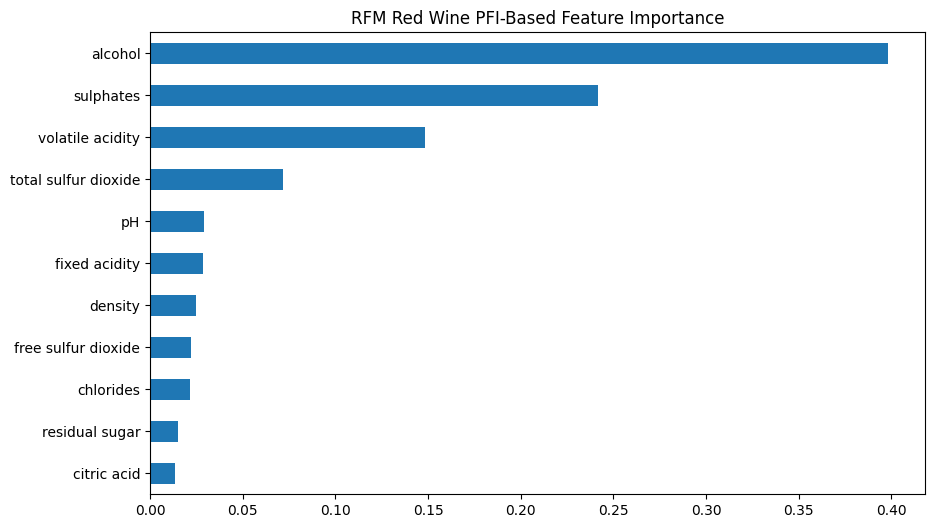

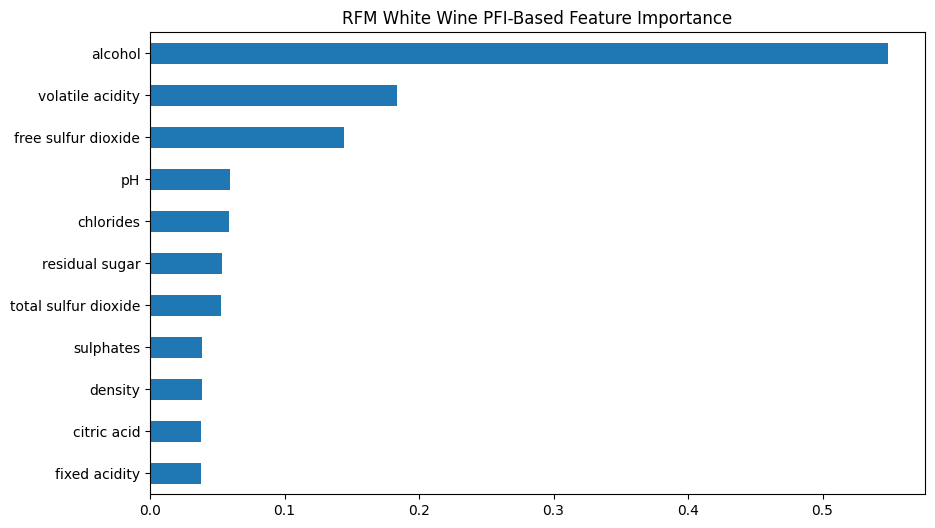

In [6]:
# PFIの計算とプロット
def plot_pfi(model, X_test, y_test, feature_names, title, save_path):
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    importances = pd.Series(result.importances_mean, index=feature_names)
    importances.sort_values().plot(kind='barh', figsize=(10, 6))
    plt.title(title)
    plt.savefig(save_path)
    plt.show()

plot_pfi(rf_model_red, X_test_red, y_test_red, X_red.columns, 'RFM Red Wine PFI-Based Feature Importance', './result/RFM_PFI_red_wine_feature_importance.png')
plot_pfi(rf_model_white, X_test_white, y_test_white, X_white.columns, 'RFM White Wine PFI-Based Feature Importance', './result/RFM_PFI_white_wine_feature_importance.png')

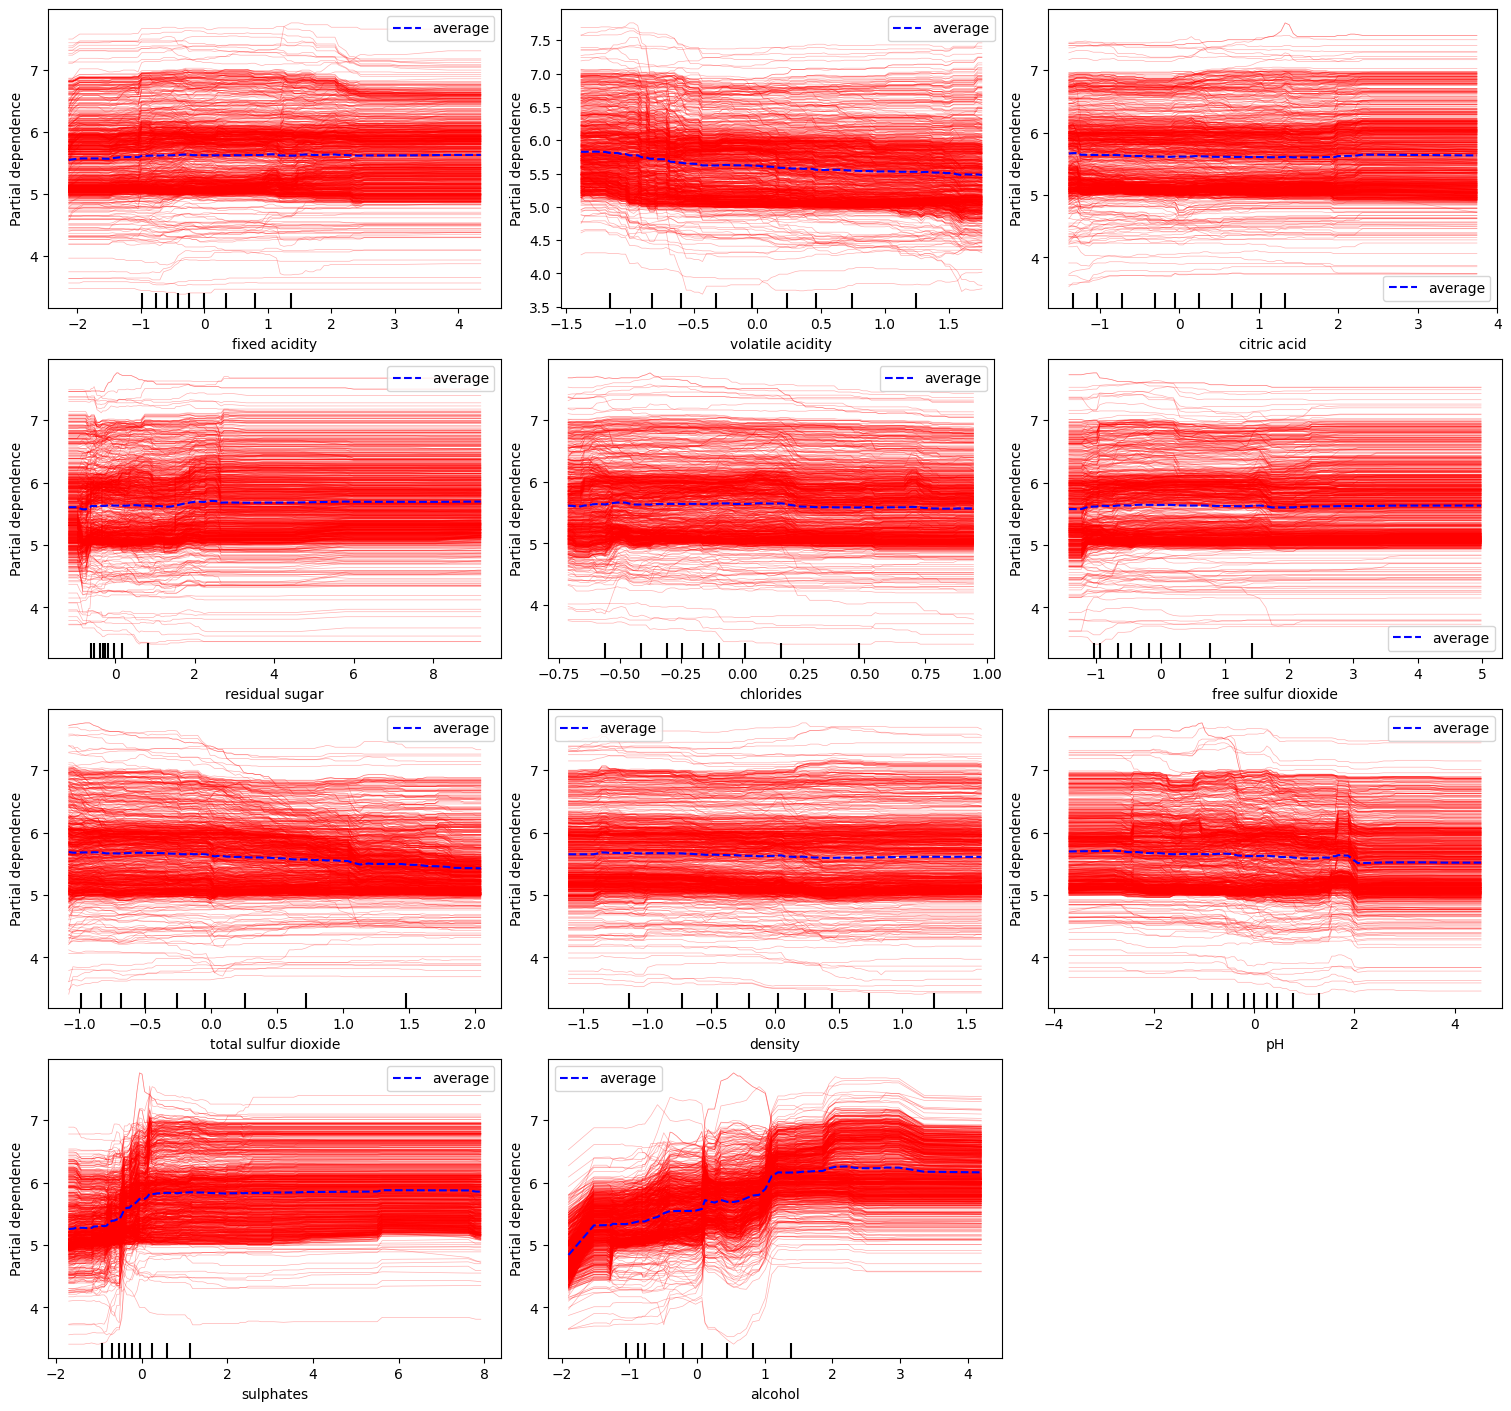

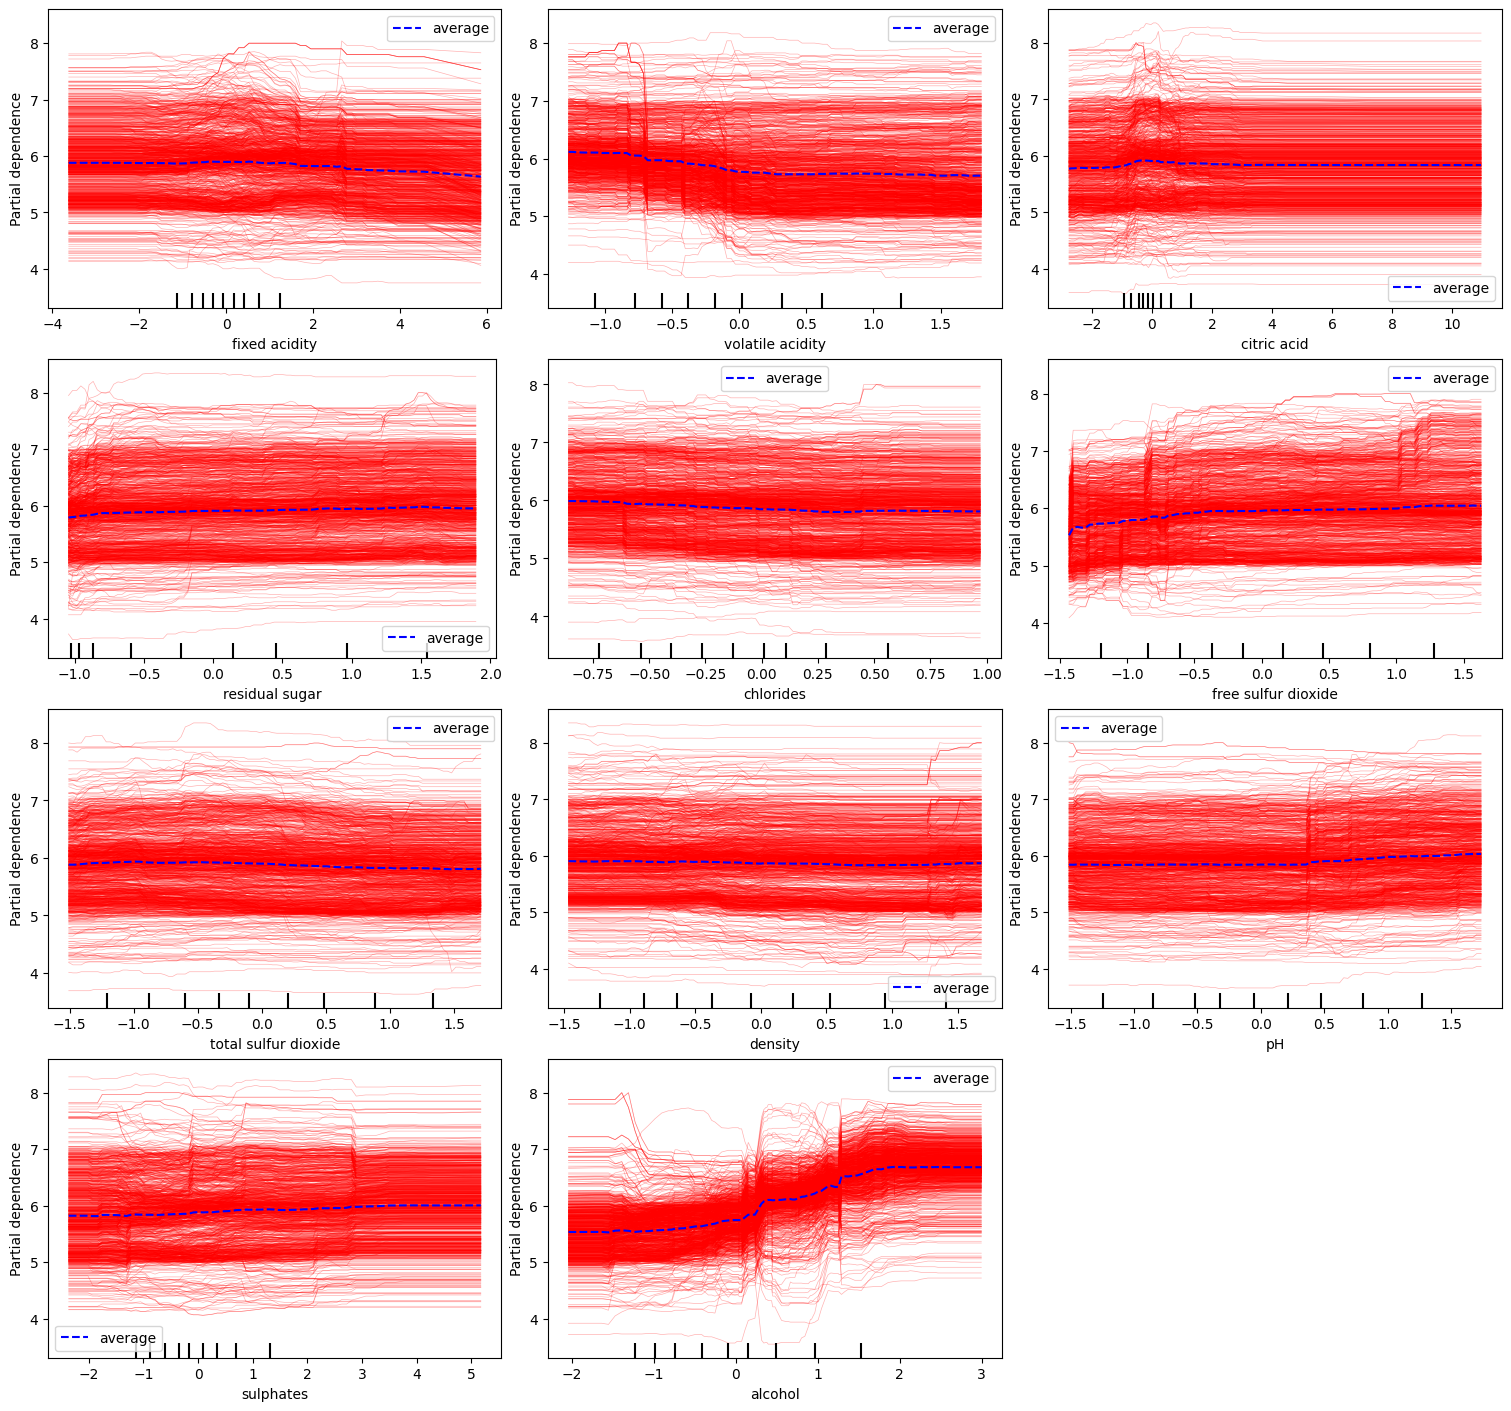

In [8]:
# 特徴量ごとにPDとICEプロットを生成する関数
def plot_pd_ice(model, X_train, features, n_cols, save_path):
    n_rows = (len(features) + n_cols - 1) // n_cols  
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.5 * n_rows), constrained_layout=True)

    # 各特徴量に対するPDとICEのプロット
    for i, feature in enumerate(features):
        ax = axs[i // n_cols, i % n_cols]
        display = PartialDependenceDisplay.from_estimator(
            model,
            X_train,  # データフレームを使って表示
            features=[feature],
            kind="both",  # PDとICEの両方を表示
            ax=ax,
            line_kw={"color": "red"},  # ICEの線の色を設定
            pd_line_kw={"color": "blue"}  # PDの線の色を設定
        )
        ax.set_title(feature)
    
    # 余分なグラフスペースを削除
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axs[j // n_cols, j % n_cols])

    # プロットの保存
    fig.savefig(save_path)
    plt.show()

# 特徴量ごとにPDとICEプロットを生成
plot_pd_ice(rf_model_red, X_train_red, X_red.columns, 3, './result/RFM_Red_wine_partial_dependence_plots.png')
plot_pd_ice(rf_model_white, X_train_white, X_white.columns, 3, './result/RFM_White_wine_partial_dependence_plots.png')
